In [5]:
!pip install lmdb
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.1 MB/s eta 0:00:00


In [32]:
import sys
sys.path.insert(0, "/kaggle/input/scropts-ocr")
import os
from torchvision.models import resnet18
import cv2
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pytorch_metric_learning.losses import ArcFaceLoss
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

In [18]:
root = '/kaggle/input/hierogliphs'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = '/kaggle/input/scropts-ocr/gt.txt'

In [8]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)
train_helper, val_helper = train_helper.train_val_split()

In [9]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper

    def __len__(self):
        return self.helper.size()

    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        img = cv2.resize(img, (128, 128))
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        img = (img - 127.5) / 255.
        return img, label

In [10]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=4)


In [41]:
class ResNet(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.resnet = resnet18()
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, embedding_size)
        
    def forward(self, x):
        x = self.resnet(x.expand(-1, 3, -1, -1))
        return x

In [42]:
model = ResNet()
model = model.cuda()

In [43]:
optim = torch.optim.AdamW(model.parameters())
loss_fn = ArcFaceLoss(num_classes=train_helper.vocabulary.num_classes(), embedding_size=512).to('cuda')

In [47]:
def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    model.train()
    global losses 
    

    for batch, (X, y) in enumerate(tqdm(train_loader)):
        logits = model(X.to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        if batch % 10 == 0:
                clear_output(wait=True)
                plt.plot(losses, label='Training Loss')
                plt.show()

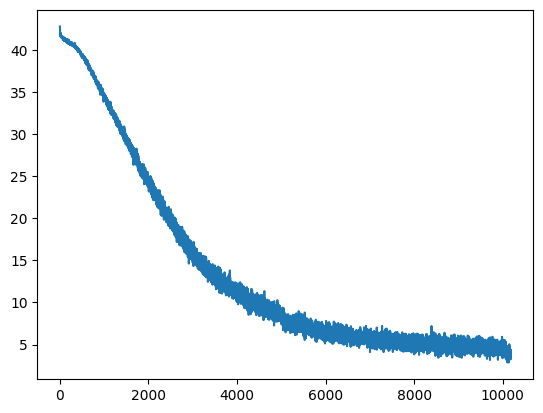

  2%|▏         | 117/5036 [00:39<27:42,  2.96it/s]


KeyboardInterrupt: 

In [48]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    train_epoch(train_loader, val_loader, model, optim, loss_fn)

In [49]:
test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=4)

In [50]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.to(torch.float32).cuda())
        classes = torch.argmax(loss_fn.get_logits(logits), dim=1).cpu().numpy()
        preds.extend(classes)

100%|██████████| 380/380 [02:56<00:00,  2.16it/s]


In [51]:
pred_path = './pred.txt'
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [52]:
from evaluate import evaluate
evaluate(gt_path, pred_path)

0.9423893432647842

In [54]:
torch.save(model.state_dict(), "model.pth")
torch.save(loss_fn.state_dict(), 'loss.pth')